# Hospital Readmission within 6 months Prediction

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_visualisation import plot_class_counts, plot_distributions
from src.process import remove_dead_patients, analyze_categorical_features
from src.utils import load_data

%load_ext autoreload
%autoreload 2


### Import and Inspect data

In [4]:
df = load_data('../data/raw/dat.csv')

In [5]:
print("Number of patients:", df.shape[0])
print("Number of features:", df.shape[1])

# Check available features 
print(", \n".join(df.columns))

Number of patients: 2008
Number of features: 167
Unnamed: 0, 
inpatient.number, 
DestinationDischarge, 
admission.ward, 
admission.way, 
occupation, 
discharge.department, 
visit.times, 
gender, 
body.temperature, 
pulse, 
respiration, 
systolic.blood.pressure, 
diastolic.blood.pressure, 
map, 
weight, 
height, 
BMI, 
type.of.heart.failure, 
NYHA.cardiac.function.classification, 
Killip.grade, 
myocardial.infarction, 
congestive.heart.failure, 
peripheral.vascular.disease, 
cerebrovascular.disease, 
dementia, 
Chronic.obstructive.pulmonary.disease, 
connective.tissue.disease, 
peptic.ulcer.disease, 
diabetes, 
moderate.to.severe.chronic.kidney.disease, 
hemiplegia, 
leukemia, 
malignant.lymphoma, 
solid.tumor, 
liver.disease, 
AIDS, 
CCI.score, 
type.II.respiratory.failure, 
consciousness, 
eye.opening, 
verbal.response, 
movement, 
respiratory.support., 
oxygen.inhalation, 
fio2, 
acute.renal.failure, 
LVEF, 
left.ventricular.end.diastolic.diameter.LV, 
mitral.valve.EMS, 
mitral.valve

In [6]:
# Remove dead patients and features in the dataset
df_no_dead = remove_dead_patients(df)

df_no_dead_future =df_no_dead.drop(['re.admission.within.3.months','re.admission.within.28.days','time.of.death..days.from.admission.',
                                    're.admission.time..days.from.admission.','return.to.emergency.department.within.6.months',
                                    'time.to.emergency.department.within.6.months'], axis=1)


Percentage of patients who died within 6 months: 0.00%

Removed features: death.within.6.months, death.within.3.months, death.within.28.days


Removing death-related features, which account for just 2.84% of the patient data, reduces bias by preventing data leakage. These features provide information about patients that would not be available at prediction time, such as outcomes directly tied to mortality. Including them could skew the model toward unrealistic patterns, such as associating death with no readmission, compromising its ability to generalize to living patients. By excluding these features and removing the small subset of deceased patients, the model can focus on clinically relevant predictors of readmission, ultimately improving fairness, accuracy, and real-world applicability.

### Split dataset into train a test set

In [7]:
from src.utils import split_and_save_dataset

train, test = split_and_save_dataset(df_no_dead_future, target_column='re.admission.within.6.months', output_dir='../data/raw/', test_size=0.2, random_state=42)

Train and test sets have been saved to:
- ../data/raw//train.csv
- ../data/raw//test.csv


# Exploratory Data Analysis

re.admission.within.6.months
0    938
1    618
dtype: int64


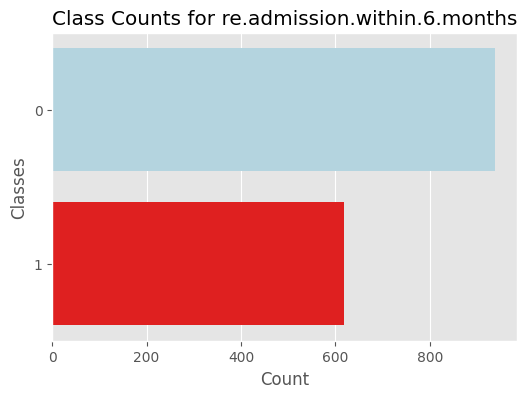

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months
0,1702,772931,Unknown,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,37.7,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",0
1,1149,807688,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.4,...,98.0,115.0,97.6,14.7,1.10,105.0,15,4,"(49,59]",0
2,596,761208,Home,Cardiology,NonEmergency,Others,Cardiology,1,Female,36.2,...,97.0,98.0,96.8,14.5,1.16,130.0,15,8,"(69,79]",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1672,831820,HealthcareFacility,Cardiology,Emergency,UrbanResident,Cardiology,1,Female,36.4,...,99.0,161.0,97.1,15.4,1.07,83.0,15,10,"(69,79]",1
1554,707,843341,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.2,...,98.0,125.0,98.1,17.1,1.16,134.0,15,8,"(69,79]",0
1555,436,738288,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,36.2,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",1


In [8]:
x = train.copy()
y = train['re.admission.within.6.months']

# Plot class counts
%matplotlib inline
plot_class_counts(x, 're.admission.within.6.months')
x

In [9]:
# Split into numerical and categorical variables based on dtypes
numerical_var = x.select_dtypes(include=['int64', 'float64'])  # Numerical features
categorical_var = x.select_dtypes(include=['object'])  # Categorical features

# Print numerical variables in a readable format
print("Numerical Variables:")
print("\n".join(numerical_var.columns))

# Print categorical variables in a readable format
print("Categorical Variables:")
print("\n".join(categorical_var.columns))

Numerical Variables:
Unnamed: 0
inpatient.number
visit.times
body.temperature
pulse
respiration
systolic.blood.pressure
diastolic.blood.pressure
map
weight
height
BMI
myocardial.infarction
congestive.heart.failure
peripheral.vascular.disease
cerebrovascular.disease
dementia
Chronic.obstructive.pulmonary.disease
connective.tissue.disease
peptic.ulcer.disease
diabetes
moderate.to.severe.chronic.kidney.disease
hemiplegia
leukemia
malignant.lymphoma
solid.tumor
liver.disease
AIDS
CCI.score
eye.opening
verbal.response
movement
fio2
acute.renal.failure
LVEF
left.ventricular.end.diastolic.diameter.LV
mitral.valve.EMS
mitral.valve.AMS
EA
tricuspid.valve.return.velocity
tricuspid.valve.return.pressure
creatinine.enzymatic.method
urea
uric.acid
glomerular.filtration.rate
cystatin
white.blood.cell
monocyte.ratio
monocyte.count
red.blood.cell
coefficient.of.variation.of.red.blood.cell.distribution.width
standard.deviation.of.red.blood.cell.distribution.width
mean.corpuscular.volume
hematocrit
lymp

## Categorical Features

In [10]:
# Check for nan, categories in each feature
analyze_categorical_features(categorical_var)

# Remove 'respiratory.support.' since it contains most of nan
df_cat = categorical_var.copy()
df_cat.drop('respiratory.support.', axis=1, inplace=True)

Categorical Feature Analysis

Missing Values:
                      Count  Percentage
occupation               22    1.413882
respiratory.support.   1528   98.200514

Value Counts:
DestinationDischarge
Home                  1059
HealthcareFacility     342
Unknown                155
Name: count, dtype: int64
Total Unique Values: 3
----------------------------------------
admission.ward
Cardiology     1199
GeneralWard     206
Others          139
ICU              12
Name: count, dtype: int64
Total Unique Values: 4
----------------------------------------
admission.way
NonEmergency    821
Emergency       735
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
occupation
UrbanResident    1289
farmer            155
Others             71
worker             12
Officer             7
Name: count, dtype: int64
Total Unique Values: 5
----------------------------------------
discharge.department
Cardiology     1324
GeneralWard     192
Others           36
ICU   

In [11]:
%matplotlib qt

plot_distributions(df_cat, y, 're.admission.within.6.months')

From this representation, it is clear that some variables are not at all discriminative (within a category, there is not such different regarding the variable to predict). The following features were dropped:
- 'admission.way', 
- 'discharge.department', 
- 'type.II.respiratory.failure', 
- 'consciousness',
- 'oxygen.inhalation', 

In [12]:
from src.process import process_cat_variables

df_cat_final = process_cat_variables(df_cat)

plot_distributions(df_cat_final, y, 're.admission.within.6.months')


#### Binary variables

In [13]:
# Binary variables as categorical
binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
                   'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease',
                   'diabetes','moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma',
                   'solid.tumor','liver.disease','AIDS','acute.renal.failure']

# Add binary variables to the categorical dataframe                   
df_binary = numerical_var[binary_variables]

# Drop binary variables from the numerical dataframe
df_numerical = numerical_var.drop(labels=binary_variables, axis=1, inplace=False)

df_binary

,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,peptic.ulcer.disease,diabetes,moderate.to.severe.chronic.kidney.disease,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,liver.disease,AIDS,acute.renal.failure
0,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1,0,1,0,0,0,0,1,0.0,0,0.0,0,0,0,0,0.0,0,0
2,0,1,0,0,1,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1554,0,1,0,1,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1555,0,1,0,0,0,0,0,0.0,1,0.0,0,0,0,0,0.0,0,0


In [14]:
from src.data_visualisation import plot_binary_distributions

analyze_categorical_features(df_binary)
plot_distributions(df_binary, y, 're.admission.within.6.months')
# plot_binary_distributions(df_binary, y, 're.admission.within.6.months')

Categorical Feature Analysis

Missing Values:
                                           Count  Percentage
peptic.ulcer.disease                           1    0.064267
moderate.to.severe.chronic.kidney.disease      2    0.128535
liver.disease                                  1    0.064267

Value Counts:
myocardial.infarction
0    1447
1     109
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
congestive.heart.failure
1    1458
0      98
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
peripheral.vascular.disease
0    1480
1      76
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
cerebrovascular.disease
0    1444
1     112
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
dementia
0    1470
1      86
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
Chronic.obstructive.pulmonary.disease

In [15]:
from src.process import process_binary_variables

df_binary_new_var = process_binary_variables(df_binary)

plot_distributions(df_binary_new_var, y, 're.admission.within.6.months')

var_to_drop = ['myocardial.infarction','peripheral.vascular.disease','cerebrovascular.disease',
               'AIDS','acute.renal.failure','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease','connective.tissue.disease','peptic.ulcer.disease','dementia',
                'Chronic.obstructive.pulmonary.disease', 'cancer', 'chronic_heart_pulmonary_disease']
df_bin_final = df_binary_new_var.drop(var_to_drop, axis=1)

plot_distributions(df_bin_final, y, 're.admission.within.6.months')

## Analyse Ordinal variables

In [16]:
ordinal_features=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']

df_ordinal = df_numerical[ordinal_features]

plot_distributions(df_ordinal, y, 're.admission.within.6.months')

# keep only 'CCI.score' and as a numerical, the others do not seem relevant
df_num = df_numerical.drop(labels=['visit.times','eye.opening','verbal.response','movement','GCS'], axis=1)
df_num

,Unnamed: 0,inpatient.number,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,...,carboxyhemoglobin,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,dischargeDay,re.admission.within.6.months
0,1702,772931,37.7,106,19,105,60,75.000000,46.0,1.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
1,1149,807688,36.4,85,19,124,64,84.000000,55.0,1.60,...,0.1,37.0,98.0,115.0,97.6,14.7,1.10,105.0,4,0
2,596,761208,36.2,92,19,146,82,103.333333,53.0,1.50,...,0.3,37.0,97.0,98.0,96.8,14.5,1.16,130.0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1672,831820,36.4,80,17,106,64,78.000000,49.0,1.60,...,1.0,37.0,99.0,161.0,97.1,15.4,1.07,83.0,10,1
1554,707,843341,36.2,63,18,120,86,97.333333,49.0,1.45,...,0.1,37.0,98.0,125.0,98.1,17.1,1.16,134.0,8,0
1555,436,738288,36.2,76,18,130,66,87.333333,67.5,1.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,1


## Numerical Features

In [17]:
from src.data_visualisation import plot_pairplot
from src.process import check_nan_columns, drop_high_nan_columns, create_exam_feature

check_nan_columns(df_num, threshold=0.3)

# Feature engineering: create variable "exam" and add it to the binary dataframe
df_bin_final = create_exam_feature(df_num, df_bin_final)

df_num_no_nan = drop_high_nan_columns(df_num, threshold=0.3)

How many columns with %NaN > 30.0%? 41
left.ventricular.end.diastolic.diameter.LV: 34.51%
reduced.hemoglobin: 50.58%
measured.residual.base: 50.58%
lactate: 50.58%
chloride.ion: 50.58%
potassium.ion: 50.58%
glucose.blood.gas: 50.58%
sodium.ion: 50.58%
hematocrit.blood.gas: 50.58%
partial.pressure.of.carbon.dioxide: 50.58%
methemoglobin: 50.58%
total.carbon.dioxide: 50.58%
standard.bicarbonate: 50.58%
standard.residual.base: 50.58%
pH: 50.58%
measured.bicarbonate: 50.58%
free.calcium: 50.58%
anion.gap: 50.58%
oxyhemoglobin: 50.58%
partial.oxygen.pressure: 50.58%
oxygen.saturation: 50.58%
body.temperature.blood.gas: 50.58%
carboxyhemoglobin: 50.58%
total.hemoglobin: 50.58%
mitral.valve.EMS: 51.09%
high.sensitivity.protein: 52.89%
tricuspid.valve.return.velocity: 60.03%
LVEF: 67.54%
glutamic.oxaliplatin: 70.44%
mitral.valve.AMS: 73.46%
Inorganic.Phosphorus: 79.95%
serum.magnesium: 79.95%
EA: 80.59%
myoglobin: 80.78%
erythrocyte.sedimentation.rate: 85.15%
lipoprotein: 91.45%
apolipoprotein

In [19]:
from src.data_visualisation import plot_num_var_histograms, plot_boxplots, plot_outliers_per_subject, plot_outliers_per_feature
# Check the distribution of numerical variables
plot_num_var_histograms(df_num_no_nan)
# plot_pairplot(df_num_no_nan, max_features=15)
# only 'glomerular.filtration.rate' seems to be discrimninative

#### Outliers analysis

In [20]:
# %matplotlib inline
# To investigate the presence of outliers, we can also plot the boxplots of these variables:
columns = ['BMI', 'total.bile.acid', 'standard.deviation.of.red.blood.cell.distribution.width']
plot_boxplots(df_num, columns)

In [21]:
from scipy.stats import zscore
# train_labels = train_fold[0]['re.admission.within.6.months']
train_labels = y
train_features = df_num

# 1. Perform z-scoring 
feature_list = df_num.columns.tolist()
print('Train subjects before outlier removal: ' + str(train_features.shape))

# apply zscore
zscore_features = df_num.apply(zscore, axis=0)
abs_zscores = abs(zscore_features)

# plot_outliers_analysis(abs_zscores)
plot_outliers_per_subject(abs_zscores)
plot_outliers_per_feature(abs_zscores)

Train subjects before outlier removal: (1556, 121)


['body.temperature',
 'pulse',
 'respiration',
 'systolic.blood.pressure',
 'diastolic.blood.pressure',
 'map',
 'weight',
 'height',
 'BMI',
 'fio2',
 'dischargeDay']

Clealy, not all these values are really outliers: indeed, dealing with pathological conditions, many of these values are due to pathology itself. 
In particular, analyzing each of these features, only the following cases were found to be outliers, probably due to wrong entries:
-  'systolic.blood.pressure', 'diastolic.blood.pressure', 'map' = 0 values. 
- 'weight' = 0, 
- 'height' = 0.35cm
- 'BMI' = 404 


These were converted in NaN values. To do this, we define a class which we will then be able to use in the final Pipeline: this class will convert these specific conditions into NaN and will, in the end, drop the features characterized by a percentage of NaN values > 40%.

In [144]:
from src.process import OutlierToNan

# Create an instance of the transformer
outlier_transformer = OutlierToNan(move_outliers=True, nan_threshold=0.4)

# Apply it to a DataFrame
df_num_final  = outlier_transformer.transform(df_num_no_nan)


#### NaN values analysis

As already said, features with a percentage of nan > 30% were simply removed from the dataset, since the imputation would have been biased and deleting the rows would have reduced the sample size too much. 

For the remaining variables, different possibilities were investigated, namely:
- Simple Imputation with mean
- Simple Imputation with median
- Iterative Imputation (MICE) considering a different number of nearest features (10,12,15). 

The following lines of code will show this analysis, which follows these steps:
1) Split the training fold into numerical and categorical variables, as shown above. 
3) Apply different imputation methods and verify which brings to a better f1 score.

In [ ]:
# Comparison of imputation methods
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
import sklearn
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score

# 1) Split the training fold into numerical and categorical variables


# 2) Convert outliers to NaN and remove features with a percentage of nan > 40% 
pipe1 = Pipeline([
        ('outlier_to_Nan', OutlierToNan()),
        ])
new_num = pipe1.fit_transform(df_numerical)
num_attributes=new_num.columns
arr_min = new_num.min()
arr_max = new_num.max()

# 3) Apply different imputation methods and verify which brings to a better f1 score
N_SPLITS=3
br_estimator = RandomForestClassifier()

# Estimate the score after single imputation (mean and median strategies): 
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator)
    score_simple_imputer[strategy] = cross_val_score(
        estimator, new_num, y1, scoring="f1", cv=N_SPLITS
    )   

# Estimate the score after iterative imputation of the missing values with different numbers of nearest features (10,12,15)
score_iterative_imputer = pd.DataFrame()
sorted(sklearn.metrics.SCORERS.keys())
n_features = (10,12,15)
for nf in n_features:
    estimator = make_pipeline(
        IterativeImputer(
            missing_values=np.nan,
            random_state=0,
            sample_posterior=True,
            n_nearest_features = nf,
            min_value = arr_min,
            max_value =arr_max
        ),
        br_estimator,
    )
    score_iterative_imputer[nf] = cross_val_score(
        estimator, new_num, y1, scoring="f1", cv=N_SPLITS
    )

score_iter_imputer = pd.DataFrame(score_iterative_imputer)

scores = pd.concat(
    [score_simple_imputer, score_iter_imputer],
    keys=["SimpleImputer", "IterativeImputer"],
    axis=1)
scores

SimpleImputer           IterativeImputer                    
           mean    median               10        12        15
0      0.256410  0.274809         0.305344  0.247012  0.253846
1      0.266160  0.355072         0.304348  0.311111  0.294964
2      0.384342  0.352941         0.324324  0.322344  0.368231

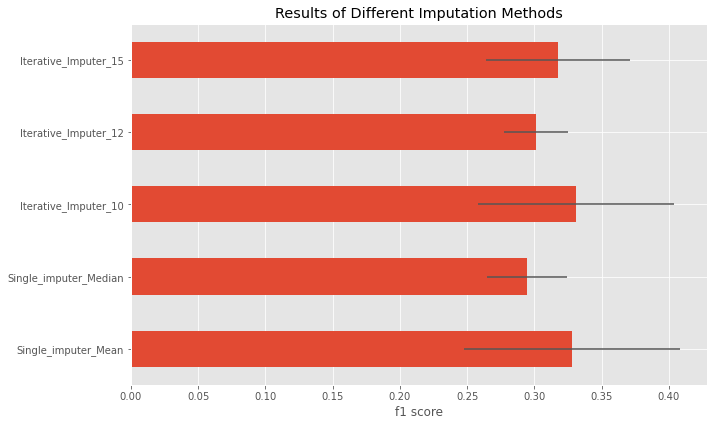

In [ ]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
means, errors = scores.mean(), scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Results of Different Imputation Methods")
ax.set_xlabel("f1 score")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(["Single_imputer_Mean", "Single_imputer_Median", "Iterative_Imputer_10","Iterative_Imputer_12","Iterative_Imputer_15"])
plt.tight_layout(pad=1)
plt.show()

In [54]:
means, errors = scores.mean(), scores.std()
means

SimpleImputer     mean      0.302304
                  median    0.327608
IterativeImputer  10        0.311339
                  12        0.293489
                  15        0.305680
dtype: float64

In the end, the IterativeImputer with 10 nearest features method was chosen. 